# 3-6. 프로젝트: 고양이 수염 스티커 만들기

카메라 스티커앱을 만드는 프로젝트이다. 



프로젝트의 진행 순서는 다음과 같다.

1. 이미지 불러오기
2. 얼굴 검출
3. 랜드마크 검출
4. 스티커 위치 정하기
5. 스티커 적용하기
6. 문제점

## 1. 이미지 불러오기

### 1.1 셀카 불러오기

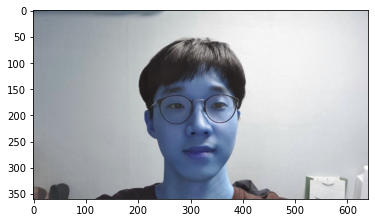

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

opencv는 이미지 채널이 matplotlib, dlib과 다르게 이미지 채널이 BGR 순서다.  
RGB 순서로 바꾸기 위해서 색깔 보정 처리를 해준다.

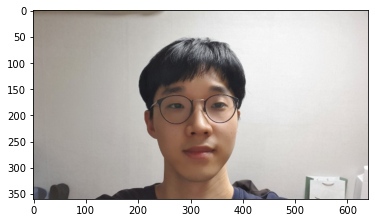

In [2]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

###  1.2 고양이 수염 이미지 다운로드

다음의 flaction 사이트에서 고양이 수염 이미지를 다운로드 받는다.  
https://www.flaticon.com/free-icon/cat-whiskers_24674?term=cat%20nose&page=1&position=1

## 2. 얼굴 검출

프로젝트에서는 dlib 패키지를 사용한다.

얼굴을 검출하기 위해서 dlib.get_frontal_face_detector() 함수를 이용하고 얼굴의 바운딩 박스를 찾는다. 이 방법은 HOG(Histogram of Oriented Gradient) feature를 사용해서 SVM(Support Vector Machine)의 슬라이딩 윈도우 기법을 사용한다. 


In [3]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

# etector를 이용해서 얼굴의 bounding box를 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

dlib은 rgb 이미지를 입력으로 받기 때문에 cvtColor() 를 이용해서 opencv 의 bgr 이미지를 rgb로 변환하였다.

detector_hog의 두 번째 파라미터는 이미지 피라미드의 수인데, 이는 이미지를 upsampling 방법을 통해 크기를 키운다. 이미지 피라미드에서 얼굴을 다시 검출하면 작게 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능하다.

rectangles[[(221, 139) (407, 325)]]


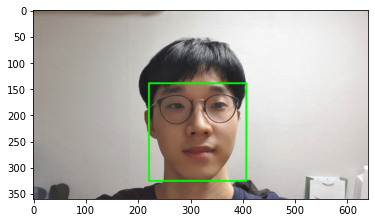

In [4]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

얼굴을 검출하였고, Bounding Bow의 좌표는 (221, 139) (407, 325)이다.

## 3. 얼굴 랜드마크 검출

얼굴 이미지에서 68개의 이목구비 위치를 찾는다.

Dlib의 제공되는 모델을 사용한다. 먼저 공개되어 있는 weight file을 다운로드 받았다. 위치는 root 디렉토리의 models 디렉토리이다. 해당 모델파일은 bz2 압축파일 형태로 제공되어 압축을 풀어준 후 사용하였다.

In [5]:
#! wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
#! mv shape_predictor_68_face_landmarks.dat.bz2 ~/aiffel/camera_sticker/models
#! cd ~/aiffel/camera_sticker && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2

### 3.1 얼굴 랜드마크 모델 불러오기

In [6]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환한다.

In [7]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


points 는 dlib.full_object_detection 의 객체이기 때문에 parts() 함수로 개별 위치에 접근가능하다. 각 좌표를 (x, y) 형태로 변환하였다. 따라서 list_points 는 tuple (x, y) 68개로 이루어진 리스트가 된다. 이미지에서 찾아진 얼굴 개수마다 반복하면 list_landmark에 68개의 랜드마크가 얼굴 개수만큼 저장된다.

### 3.2 얼굴 랜드마크 출력

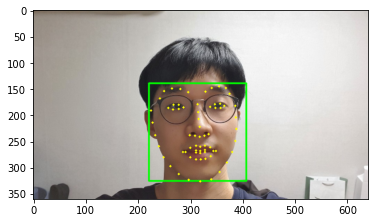

In [8]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 4. 스티커 위치 정하기

### 스티커 좌표 및 코 끝 좌표 확인

스티커 좌표를 다음과 같이 설정하였다. 고양이 스티커의 시작점이 볼의 가운데에 위치시키기 위하여 왼쪽 볼의 끝과 코 끝의 중간지점으로 두었다.

스티커의 크기는 너비와 높이로 이루어진다. 
너비는 코 끝 좌표를 중심으로 스티커가 시작하는 구간의 2배이고, 높이는 얼굴을 검출한 Bounding Box의 $\frac{1}{3}$로 두었다.

코 끝의 좌표는 얼굴 랜드마크의 30번이다.
  
  
1. 스티커 위치  
  
    $x = \frac{landmark[1]의 x 좌표 + x_{nose}}{2} $  
    $x = \frac{landmark[1]의 y 좌표 + landmark[36]의 y 좌표  }  { 2}$
     
     
2. 스티커 크기  
  
    $width = ({x_{nose} - x_{1}})*2 $  
    $height = \frac{width_{bbox}}{3} $
      
      
3. 코의 위치 
  
    $x = x_{nose}$  
    $x = y_{nose}$
     
     

In [9]:
x1 = (landmark[1][0] + landmark[30][0]) / 2
y1 = (landmark[1][1] + landmark[36][1]) / 2
print ('(x,y) : (%d,%d)'%(x1, y1))

(x,y) : (273,200)


In [10]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1]
    w = int((landmark[30][0] - x1) * 2)
    h = int(dlib_rect.width() / 3)
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(318, 222)
(x,y) : (318,222)
(w,h) : (90,62)


코의 중심점이 (318, 222)로 나왔다.  
너비는 90, 높이는 62이다.

## 5. 스티커 적용하기

### 5.1 스티커 Resizing

준비한 고양이 수염 스티커를 읽어 적용한다.  
고양이 수염 이미지를 읽고 윗 단계에서 계산한 크기로 resize한다.

In [11]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)

(62, 90, 3)


In [12]:
refined_x = int(x1)  # left
refined_y = int(y1)  # top
print ('(x1,y1) : (%d,%d)'%(refined_x, refined_y))

(x1,y1) : (273,200)


스티커가 시작하는 지점은 (273,200)이다.

### 5.2 스티커 적용 및 배경 제거

원본 이미지에 스티커를 적용한다.

In [13]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지이다.

왕관 예제에서는 0 이 아닌 색이 있는 부분을 사용했지만, 스티커 이미지에서 사용할 부분은 255 이 아닌 색이 있는 부분을 사용한다. 이유는 흰색의 색상 번호는 255인데 스티커 이미지의 흰색 배경을 제외하기 위함이다.

따라서 np.where를 통해 img_sticker 가 255 인 부분은 sticker_area를 사용하고 255가 아닌 부분을 img_sticker를 사용한다. img_show 에 다시 적용하였다.

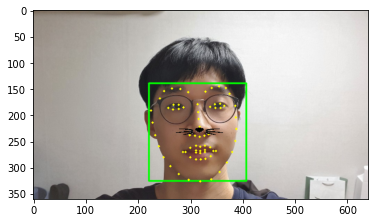

In [14]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 5.2 최종 결과 출력

bounding box와 landmark를 제거하고 최종 결과를 출력한다.  

고양이 수염 스티커가 코 끝에 잘 적용된 것을 확인할 수 있다.

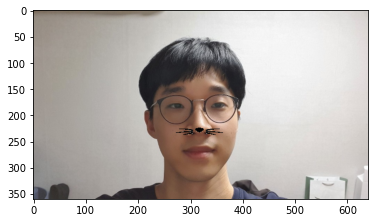

In [15]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 6. 문제점 찾아보기

(1) 셀프 카메라를 다양한 각도에서 촬영하면서 스티커를 반복해서 적용해 보세요.

(2) 문제점이 무엇인지 최대한 자세하게 기록해 보세요. 여러분이 생각한 문제점을 해결하기 위한 방법은 분명 존재합니다!

## 6.1 정면이 아닌 옆모습

얼굴의 각도는 바꾸지 않고 얼굴의 한 쪽 면이 잘 보이지 않는 이미지를 불러왔다.  

얼굴 검출과 얼굴의 랜드마크를 검출하는 모습을 확인할 수 있다.

정면이 아닌 옆모습에 스티커를 적용할 때의 문제는 **스티커를 알맞은 위치에 두는 것이 어렵다.**  
정면을 기준으로 할 때는 스티커의 시작 지점을 **왼쪽 볼을 중앙 지점**으로 스티커를 놓으면 되었지만,   
옆모습에 스티커를 적용할 때는 **좌표를 일일이 찾아가며** 스티커를 적용해야 하는 문제가 있다.

### 6.1.1 이미지 불러오기 및 얼굴과 랜드마크 검출

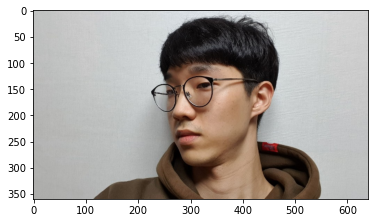

rectangles[[(191, 68) (414, 291)]]


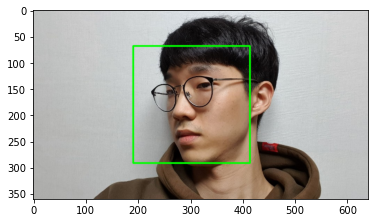

68


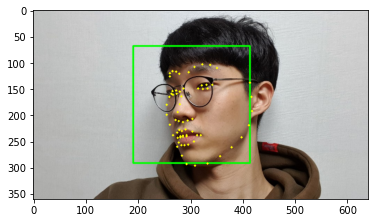

In [16]:
# 이미지 불러오기
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image_side.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

# 얼굴 검출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


# 얼굴 랜드마크 검출
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 6.1.2 옆 모습의 스티커 좌표 설정

옆 모습의 스티커 좌표를 정면의 스티커 좌표 설정 방법과 같게 하면 스티커의 위치가 잘못된 위치에 놓인다.

우리가 원하는 스티커의 위치는 코 끝이므로 알맞은 위치에 스티커를 놓기 위하여 좌표를 설정해준다.

Landmark 29번인 왼쪽 볼을 기준으로 x 축으로 50만큼 왼쪽으로, y좌표는 그대로 두었다.

스티커 시작 위치는 (230,179)이다.

In [17]:
x1 = landmark[29][0] - 50
y1 = landmark[29][1]

refined_x = int(x1)  # left
refined_y = int(y1)  # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (230,179)


코 끝의 위치는 (276,194)이고, 스티커의 너비와 높이는 각각 (92,74)이다.

In [18]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1]
    w = int((landmark[30][0] - x1) * 2)
    h = int(dlib_rect.width() / 3)
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(276, 194)
(x,y) : (276,194)
(w,h) : (92,74)


### 6.1.3 스티커 적용하기

In [19]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

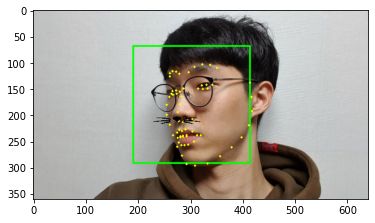

In [20]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 6.1.4 옆모습 최종 결과 출력

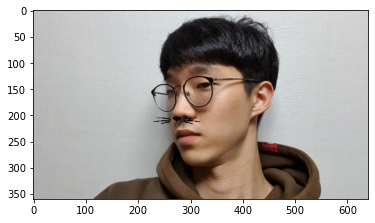

In [21]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

bounding box와 landmark를 제거하고 스티커가 적용된 옆모습의 최종 결과를 출력한다.

성공적으로 고양이 수염 스티커가 코 끝에 잘 적용된 것을 확인할 수 있다.

## 6.2 누워있는 이미지

각도가 기울어진 누워있는 이미지는 얼굴 랜드마크 검출하기 이전에 얼굴의 검출이 되지 않는다.  

dlib 패키지의 dlib.get_frontal_face_detector() 함수는 **얼굴의 정면을 기준**으로 하므로 얼굴 각도가 있으면 검출이 되지 않는다. 이를 해결하려면 이미지를 회전시킨 후에 다시 얼굴을 검출하고 앞선 프로젝트를 진행하여야 할 것이다.

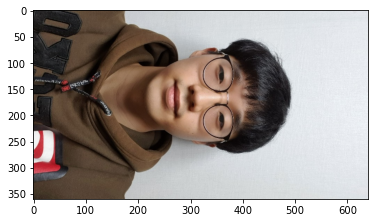

rectangles[]


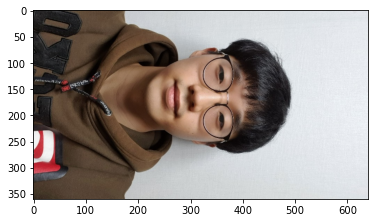

IndexError: list index out of range

In [22]:
# 이미지 불러오기
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image_lying.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

# 얼굴 검출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


# 얼굴 랜드마크 검출
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 6.3 어두운 이미지

밝기가 어두우면 얼굴을 검출하지 못한다. 

어두우면 얼굴을 인식하지 못하므로 얼굴을 검출하기 위해서는 **이미지 밝기를 밝게 만들어** 얼굴을 인식할 수 있도록 한다.

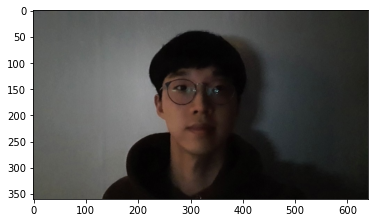

rectangles[]


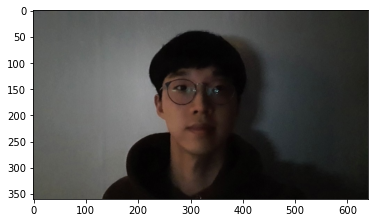

IndexError: list index out of range

In [23]:
# 이미지 불러오기
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image_dark.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

# 얼굴 검출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


# 얼굴 랜드마크 검출
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 6.4 문제점

오늘 만든 스티커앱에서 생각해볼 수 있는 문제점은 다음과 같습니다.

1. 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?  

- 스티커 또한 얼굴의 각도와 함께 각도가 따라가야하지만 이 프로젝트에서 사용한 함수로는 스티커가 각도의 변화 없이 적용되는 한계가 있다.

2. 옆으로 누워서 촬영하면 왜 안될까요?  

- 각도가 달라지면 얼굴을 검출하는 것은 가능하지만 일정 각도 이상에서는 얼굴을 검출할 수 없다. 얼굴을 검출할 수 있는 구간에서는 스티커 또한 얼굴의 각도와 함께 각도가 따라가야하지만 이 프로젝트에서 사용한 함수로는 적용할 수 없는 문제가 있다.

3. 실행 속도가 중요할까요?  

- 이 프로젝트에서는 이미지를 처리하여 진행하였지만, 영상 속에서 스티커앱을 만들 경우에는 더 빠른 실행속도가 필요할 것이다.

4. 스티커앱을 만들 때 정확도가 얼마나 중요할까요?

- 스티커가 얼굴의 목표한 위치에 정확히 들어가야하는 것은 아주 중요한 문제다. 고양이 수염 프로젝트에서 진행한 것처럼 수염이 코 끝에 정확히 위치하지 못하고 다른 부위에 존재한다면 어색하게 보일 수 밖에 없다. 따라서 스티커 앱을 만들 때 사람의 얼굴을 검출하여 스티커에 맞는 랜드마크를 잘 설정하여 진행해야한다

## 7. 총평

오픈 소스 컴퓨터 비전 라이브러리인 opencv를 이용하여 이미지 처치를 하는 프로젝트를 진행하였다. opencv의 특징은 이미지를 RGB가 아닌 BGR로 처리하기 때문에 RGB로 바꾸는 작업이 필요하다. 

프로젝트의 주요 목적은 얼굴과 얼굴 랜드마크를 검출하는 것이다. 검출한 랜드마크를 바탕으로 좌표를 찾고 스티커를 붙이는 과정을 진행하였다. 정면의 경우에는 스티커의 시작점 좌표를 볼 왼쪽 가운데로 잡으면 손쉽게 스티커를 적용할 수 있었지만, 얼굴 각도가 달라지거나 yaw가 발생할 경우 회전에 대한 이미지 처리 방법과 side face detection opencv에 대한 공부가 필요할 것이다.